# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  72.94 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 64 #128 # 64
N = 20000# 80000 # 20000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 20000
Taking FFT of the images:
Batch 1/10  5.61 sec.
Batch 2/10  5.60 sec.
Batch 3/10  5.60 sec.
Batch 4/10  5.60 sec.
Batch 5/10  5.60 sec.
Batch 6/10  5.61 sec.
Batch 7/10  5.58 sec.
Batch 8/10  5.60 sec.
Batch 9/10  5.56 sec.
Batch 10/10  5.53 sec.
FFT done. Time:  68.81 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (20000, 4096)
Mask radius = 0.0739503816793893
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  11.16 sec.


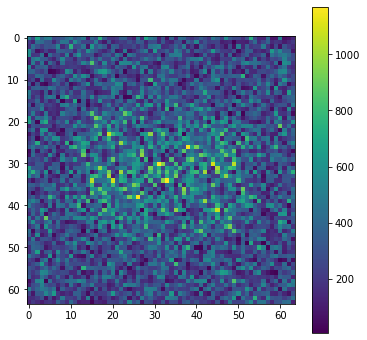

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [7]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different
* SGD seems to overfit at small batch size (e.g. 32) - better objective (??? maybe there's something wrong with how I calculate loss_epoch) but much worse FSC. Batch size = 1000 seems good for both methods, interestingly the OASIS FSC stays above 0.9 for all resolutions (up to 6.6 Angs for nx=128 -> maybe try a bit higher?).

In [8]:
sigma_noise_est = sigma_noise
sigma_noise = jnp.ones(sigma_noise.shape)
#sigma_noise = sigma_noise_est

In [9]:
sigma_noise

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float64)

In [10]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [11]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [12]:
alpha =  1e-9 # 1e-5

slice_obj = Slice(x_grid, mask = mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD and OASIS

In [13]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [14]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)


In [15]:
iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD01z += z * hvp_func1(x0, z, idx)
    zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/iters)
D02 = jnp.array(zD02z/iters)

100%|██████████| 2000/2000 [00:57<00:00, 34.60it/s]


1.0000000000000342e-09
0.028378148357412238
28378148.35741127


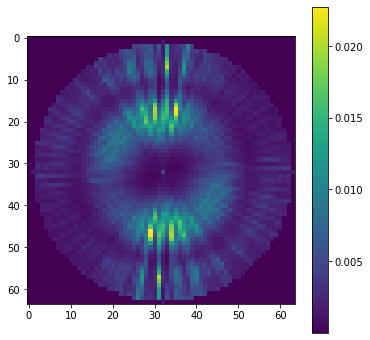

In [16]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

1.0000000000000342e-09
0.028378148357412238


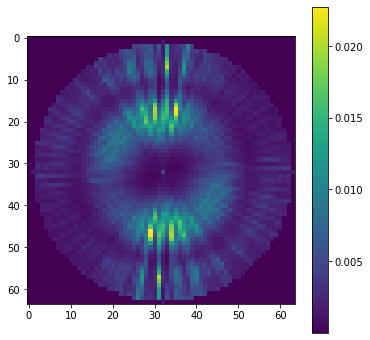

In [17]:
DD = jnp.maximum(jnp.abs(D01), 1e-9)
plt.imshow(jnp.fft.fftshift(jnp.abs(DD[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(DD)))
print(jnp.max(jnp.abs(DD)))

In [18]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02)))
print(jnp.max(jnp.abs(D01-D02)))

0.028378148357412238
0.02733485570225833
0.003150111263169355


#### SGD

In [194]:
N_epochs = 30
batch_size = 1000
step_size =  1e-2 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

# 10k imgs, 64px:
#   no sigma_noise, no precon: 1e1 V
#   no sigma_noise, with precon: 1e-2 V
#   with sigma_noise, no precon: 1e6
#   with sigma_noise, with precon: 1e-1

# 40k imgs, 128px 
#  no sigma_noise, no precon: 1e1 
#  no sigma_noise, with precon: 1e-4

# ======= not sure about the above step sizes

#  with sigma_noise, no precon: 1e5, 13 angs (1e6 is worse: 15 angs)
#  with_sigma_noise, with precon: 1e-3, 

In [195]:
#P1 = None
P1 = 1/D01

key, subkey = random.split(key)
x01 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x01, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


Epoch 1/30 

100%|██████████| 10/10 [00:01<00:00,  6.17it/s, grad=2.291e+01, loss=3.292e+08]


  |Grad| = 2.766e+01
  Loss = 3.339e+08
Epoch 2/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=1.953e+01, loss=3.232e+08]


  |Grad| = 2.125e+01
  Loss = 3.268e+08
Epoch 3/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=1.656e+01, loss=3.243e+08]


  |Grad| = 1.735e+01
  Loss = 3.228e+08
Epoch 4/30 

100%|██████████| 10/10 [00:01<00:00,  6.18it/s, grad=1.201e+01, loss=3.197e+08]


  |Grad| = 1.467e+01
  Loss = 3.205e+08
Epoch 5/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=1.359e+01, loss=3.151e+08]


  |Grad| = 1.254e+01
  Loss = 3.192e+08
Epoch 6/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=1.281e+01, loss=3.182e+08]


  |Grad| = 1.097e+01
  Loss = 3.184e+08
Epoch 7/30 

100%|██████████| 10/10 [00:01<00:00,  6.22it/s, grad=9.260e+00, loss=3.174e+08]


  |Grad| = 9.789e+00
  Loss = 3.179e+08
Epoch 8/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.845e+00, loss=3.179e+08]


  |Grad| = 8.835e+00
  Loss = 3.177e+08
Epoch 9/30 

100%|██████████| 10/10 [00:01<00:00,  6.26it/s, grad=7.479e+00, loss=3.130e+08]


  |Grad| = 8.559e+00
  Loss = 3.175e+08
Epoch 10/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.271e+00, loss=3.166e+08]


  |Grad| = 7.639e+00
  Loss = 3.174e+08
Epoch 11/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=7.863e+00, loss=3.149e+08]


  |Grad| = 7.743e+00
  Loss = 3.173e+08
Epoch 12/30 

100%|██████████| 10/10 [00:01<00:00,  6.15it/s, grad=7.216e+00, loss=3.187e+08]


  |Grad| = 7.471e+00
  Loss = 3.172e+08
Epoch 13/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=7.266e+00, loss=3.149e+08]


  |Grad| = 7.608e+00
  Loss = 3.172e+08
Epoch 14/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=8.220e+00, loss=3.157e+08]


  |Grad| = 7.421e+00
  Loss = 3.171e+08
Epoch 15/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=7.208e+00, loss=3.186e+08]


  |Grad| = 7.453e+00
  Loss = 3.171e+08
Epoch 16/30 

100%|██████████| 10/10 [00:01<00:00,  6.26it/s, grad=7.021e+00, loss=3.181e+08]


  |Grad| = 6.908e+00
  Loss = 3.171e+08
Epoch 17/30 

100%|██████████| 10/10 [00:01<00:00,  6.24it/s, grad=7.095e+00, loss=3.148e+08]


  |Grad| = 7.304e+00
  Loss = 3.171e+08
Epoch 18/30 

100%|██████████| 10/10 [00:01<00:00,  6.29it/s, grad=6.728e+00, loss=3.183e+08]


  |Grad| = 7.299e+00
  Loss = 3.171e+08
Epoch 19/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=6.941e+00, loss=3.196e+08]


  |Grad| = 7.491e+00
  Loss = 3.171e+08
Epoch 20/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=6.438e+00, loss=3.154e+08]


  |Grad| = 7.110e+00
  Loss = 3.170e+08
Epoch 21/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=6.587e+00, loss=3.155e+08]


  |Grad| = 7.320e+00
  Loss = 3.170e+08
Epoch 22/30 

100%|██████████| 10/10 [00:01<00:00,  6.26it/s, grad=6.760e+00, loss=3.183e+08]


  |Grad| = 7.496e+00
  Loss = 3.170e+08
Epoch 23/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=8.196e+00, loss=3.186e+08]


  |Grad| = 7.503e+00
  Loss = 3.170e+08
Epoch 24/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=7.951e+00, loss=3.139e+08]


  |Grad| = 7.352e+00
  Loss = 3.170e+08
Epoch 25/30 

100%|██████████| 10/10 [00:01<00:00,  6.24it/s, grad=7.001e+00, loss=3.221e+08]


  |Grad| = 7.275e+00
  Loss = 3.170e+08
Epoch 26/30 

100%|██████████| 10/10 [00:01<00:00,  6.17it/s, grad=7.251e+00, loss=3.196e+08]


  |Grad| = 7.173e+00
  Loss = 3.170e+08
Epoch 27/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=7.165e+00, loss=3.184e+08]


  |Grad| = 7.086e+00
  Loss = 3.170e+08
Epoch 28/30 

100%|██████████| 10/10 [00:01<00:00,  6.18it/s, grad=6.540e+00, loss=3.222e+08]


  |Grad| = 7.729e+00
  Loss = 3.170e+08
Epoch 29/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.584e+00, loss=3.189e+08]


  |Grad| = 7.553e+00
  Loss = 3.170e+08
Epoch 30/30 

100%|██████████| 10/10 [00:01<00:00,  6.26it/s, grad=7.082e+00, loss=3.206e+08]

  |Grad| = 7.312e+00
  Loss = 3.170e+08


In [196]:
#P2 = None
P2 = 1/D02

key, subkey = random.split(key)
x02 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x02, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


Epoch 1/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=2.512e+01, loss=3.325e+08]


  |Grad| = 2.860e+01
  Loss = 3.356e+08
Epoch 2/30 

100%|██████████| 10/10 [00:01<00:00,  6.22it/s, grad=2.109e+01, loss=3.303e+08]


  |Grad| = 2.185e+01
  Loss = 3.286e+08
Epoch 3/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=1.655e+01, loss=3.237e+08]


  |Grad| = 1.783e+01
  Loss = 3.246e+08
Epoch 4/30 

100%|██████████| 10/10 [00:01<00:00,  6.21it/s, grad=1.291e+01, loss=3.195e+08]


  |Grad| = 1.497e+01
  Loss = 3.223e+08
Epoch 5/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=1.075e+01, loss=3.202e+08]


  |Grad| = 1.344e+01
  Loss = 3.209e+08
Epoch 6/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=1.099e+01, loss=3.194e+08]


  |Grad| = 1.159e+01
  Loss = 3.201e+08
Epoch 7/30 

100%|██████████| 10/10 [00:01<00:00,  6.21it/s, grad=1.163e+01, loss=3.210e+08]


  |Grad| = 1.019e+01
  Loss = 3.197e+08
Epoch 8/30 

100%|██████████| 10/10 [00:01<00:00,  6.18it/s, grad=7.993e+00, loss=3.176e+08]


  |Grad| = 9.002e+00
  Loss = 3.194e+08
Epoch 9/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=9.015e+00, loss=3.180e+08]


  |Grad| = 8.247e+00
  Loss = 3.192e+08
Epoch 10/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=8.545e+00, loss=3.193e+08]


  |Grad| = 7.892e+00
  Loss = 3.191e+08
Epoch 11/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.312e+00, loss=3.161e+08]


  |Grad| = 7.474e+00
  Loss = 3.190e+08
Epoch 12/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=7.361e+00, loss=3.208e+08]


  |Grad| = 7.055e+00
  Loss = 3.189e+08
Epoch 13/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=7.316e+00, loss=3.152e+08]


  |Grad| = 7.408e+00
  Loss = 3.189e+08
Epoch 14/30 

100%|██████████| 10/10 [00:01<00:00,  6.24it/s, grad=7.710e+00, loss=3.182e+08]


  |Grad| = 7.277e+00
  Loss = 3.188e+08
Epoch 15/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=7.568e+00, loss=3.176e+08]


  |Grad| = 7.558e+00
  Loss = 3.188e+08
Epoch 16/30 

100%|██████████| 10/10 [00:01<00:00,  6.22it/s, grad=7.830e+00, loss=3.128e+08]


  |Grad| = 7.163e+00
  Loss = 3.188e+08
Epoch 17/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=6.557e+00, loss=3.192e+08]


  |Grad| = 7.417e+00
  Loss = 3.188e+08
Epoch 18/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=7.643e+00, loss=3.171e+08]


  |Grad| = 7.217e+00
  Loss = 3.188e+08
Epoch 19/30 

100%|██████████| 10/10 [00:01<00:00,  6.21it/s, grad=6.876e+00, loss=3.170e+08]


  |Grad| = 7.066e+00
  Loss = 3.188e+08
Epoch 20/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=8.503e+00, loss=3.186e+08]


  |Grad| = 7.322e+00
  Loss = 3.187e+08
Epoch 21/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=6.819e+00, loss=3.224e+08]


  |Grad| = 7.375e+00
  Loss = 3.187e+08
Epoch 22/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.043e+00, loss=3.188e+08]


  |Grad| = 7.641e+00
  Loss = 3.187e+08
Epoch 23/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.020e+00, loss=3.215e+08]


  |Grad| = 7.324e+00
  Loss = 3.187e+08
Epoch 24/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.031e+00, loss=3.198e+08]


  |Grad| = 7.445e+00
  Loss = 3.187e+08
Epoch 25/30 

100%|██████████| 10/10 [00:01<00:00,  6.21it/s, grad=7.076e+00, loss=3.191e+08]


  |Grad| = 7.377e+00
  Loss = 3.187e+08
Epoch 26/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=7.025e+00, loss=3.202e+08]


  |Grad| = 7.029e+00
  Loss = 3.187e+08
Epoch 27/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.192e+00, loss=3.192e+08]


  |Grad| = 7.111e+00
  Loss = 3.187e+08
Epoch 28/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=6.740e+00, loss=3.201e+08]


  |Grad| = 7.551e+00
  Loss = 3.187e+08
Epoch 29/30 

100%|██████████| 10/10 [00:01<00:00,  6.20it/s, grad=7.194e+00, loss=3.170e+08]


  |Grad| = 7.283e+00
  Loss = 3.187e+08
Epoch 30/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=7.337e+00, loss=3.204e+08]

  |Grad| = 7.383e+00
  Loss = 3.187e+08


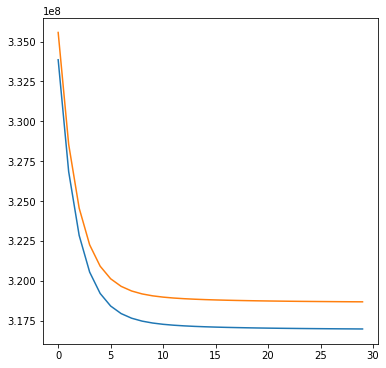

In [197]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)

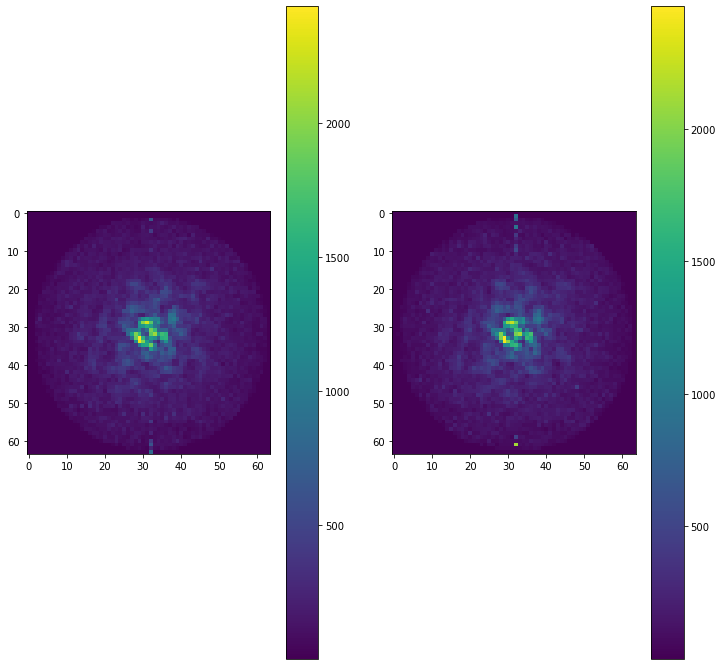

In [198]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec2))); plt.colorbar()

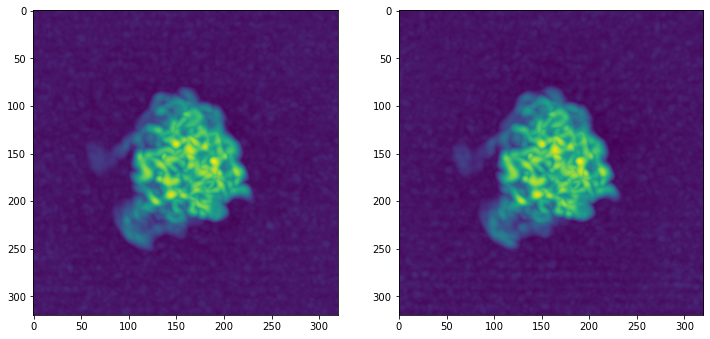

In [199]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [200]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

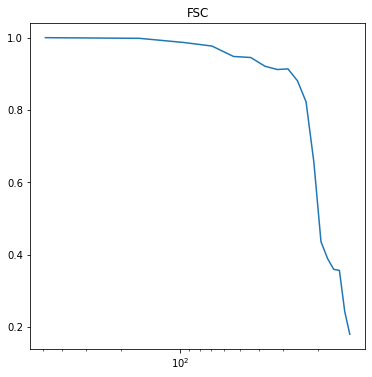

In [201]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [202]:
print(fsc_sgd[11])
print(fsc_sgd[12])
print(res_angs[11])
print(res_angs[12])

0.6566122662619037
0.4361424500636747
21.04567242124271
19.362018627543293


#### OASIS

In [345]:
from src.algorithm import *

In [349]:
N_epoch = 30 #30
beta2 = 0.99
eta0 = 1e-4 #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-16 #0.1 # 0.01

D0bad = jnp.array(np.random.randn(*D01.shape))

key, subkey = random.split(key)


# Step sizes (eta0): 
#
# 10k imgs, 64px:
#   no sigma_noise: 1e-4 (1e-3 if beta2=1)
#   with sigma_noise: 1e-4
#
# 40k imgs, 128px: 
#   no sigma_noise: 1e-4

##### not sure about the step sizes above

#   with sigma_noise: 1e-4, 9 angs;
#               1e-3: getting 7 angs, but the complex part goes up and so the loss goes up - weird. 
# I probably need to fix the handling of the complex part. And the FSC is low because I take the real
# part of the correlation. Think about this. Is it because the cmplex part is not handled properly?

In [350]:
jnp.min(D01)

DeviceArray(1.e-09+0.j, dtype=complex128)

In [370]:
key, subkey1, subkey2 = random.split(key, 3)
x01 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)
print(subkey2)

v_rec_o1, loss_o1 = oasis(subkey2, loss_func1, grad_func1, hvp_func1, x01, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


[2586243674 3330527857]
Epoch 1/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.421e+08]


  Loss =  3.396e+08
Epoch 2/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.380e+08]


  Loss =  3.396e+08
Epoch 3/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.364e+08]


  Loss =  3.395e+08
Epoch 4/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.358e+08]


  Loss =  3.395e+08
Epoch 5/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.364e+08]


  Loss =  3.395e+08
Epoch 6/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.379e+08]


  Loss =  3.395e+08
Epoch 7/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.381e+08]


  Loss =  3.394e+08
Epoch 8/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.413e+08]


  Loss =  3.394e+08
Epoch 9/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.404e+08]


  Loss =  3.394e+08
Epoch 10/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.420e+08]


  Loss =  3.394e+08
Epoch 11/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.385e+08]


  Loss =  3.394e+08
Epoch 12/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.424e+08]


  Loss =  3.393e+08
Epoch 13/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.374e+08]


  Loss =  3.393e+08
Epoch 14/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.447e+08]


  Loss =  3.393e+08
Epoch 15/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.388e+08]


  Loss =  3.393e+08
Epoch 16/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.386e+08]


  Loss =  3.393e+08
Epoch 17/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.417e+08]


  Loss =  3.393e+08
Epoch 18/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.366e+08]


  Loss =  3.392e+08
Epoch 19/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.393e+08]


  Loss =  3.392e+08
Epoch 20/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=3.403e+08]


  Loss =  3.392e+08
Epoch 21/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.385e+08]


  Loss =  3.392e+08
Epoch 22/30


100%|██████████| 10/10 [00:02<00:00,  4.02it/s, loss=3.379e+08]


  Loss =  3.392e+08
Epoch 23/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.366e+08]


  Loss =  3.392e+08
Epoch 24/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.427e+08]


  Loss =  3.392e+08
Epoch 25/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.394e+08]


  Loss =  3.391e+08
Epoch 26/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.407e+08]


  Loss =  3.391e+08
Epoch 27/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.427e+08]


  Loss =  3.391e+08
Epoch 28/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.390e+08]


  Loss =  3.391e+08
Epoch 29/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.358e+08]


  Loss =  3.391e+08
Epoch 30/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.378e+08]

  Loss =  3.391e+08


In [371]:
key, subkey1, subkey2 = random.split(key, 3)
x0 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)

#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey2, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [372]:
key, subkey1, subkey2 = random.split(key, 3)

x02 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)
print(subkey2)

v_rec_o2, loss_o2 = oasis(subkey2, loss_func2, grad_func2, hvp_func2, x02, eta0, D02, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


[2361440025 4254988229]
Epoch 1/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.382e+08]


  Loss =  3.413e+08
Epoch 2/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.426e+08]


  Loss =  3.413e+08
Epoch 3/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.394e+08]


  Loss =  3.413e+08
Epoch 4/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.404e+08]


  Loss =  3.412e+08
Epoch 5/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.475e+08]


  Loss =  3.412e+08
Epoch 6/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.393e+08]


  Loss =  3.412e+08
Epoch 7/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=3.437e+08]


  Loss =  3.412e+08
Epoch 8/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.434e+08]


  Loss =  3.411e+08
Epoch 9/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.406e+08]


  Loss =  3.411e+08
Epoch 10/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.417e+08]


  Loss =  3.411e+08
Epoch 11/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.389e+08]


  Loss =  3.411e+08
Epoch 12/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.383e+08]


  Loss =  3.411e+08
Epoch 13/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.379e+08]


  Loss =  3.410e+08
Epoch 14/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.430e+08]


  Loss =  3.410e+08
Epoch 15/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.431e+08]


  Loss =  3.410e+08
Epoch 16/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.435e+08]


  Loss =  3.410e+08
Epoch 17/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.407e+08]


  Loss =  3.410e+08
Epoch 18/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.434e+08]


  Loss =  3.409e+08
Epoch 19/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.427e+08]


  Loss =  3.409e+08
Epoch 20/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=3.339e+08]


  Loss =  3.409e+08
Epoch 21/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.443e+08]


  Loss =  3.409e+08
Epoch 22/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.385e+08]


  Loss =  3.409e+08
Epoch 23/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=3.381e+08]


  Loss =  3.409e+08
Epoch 24/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.443e+08]


  Loss =  3.409e+08
Epoch 25/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=3.404e+08]


  Loss =  3.409e+08
Epoch 26/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.420e+08]


  Loss =  3.408e+08
Epoch 27/30


100%|██████████| 10/10 [00:02<00:00,  4.01it/s, loss=3.393e+08]


  Loss =  3.408e+08
Epoch 28/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.392e+08]


  Loss =  3.408e+08
Epoch 29/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.430e+08]


  Loss =  3.408e+08
Epoch 30/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.389e+08]

  Loss =  3.408e+08


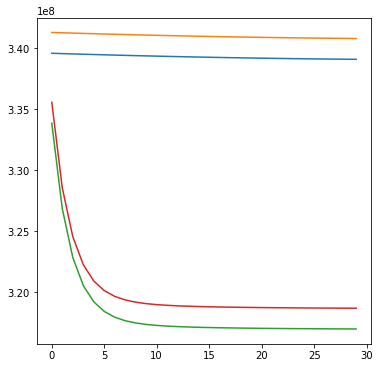

In [373]:
plt.plot(loss_o1)
plt.plot(loss_o2)
plt.plot(loss_rec1)
plt.plot(loss_rec2)


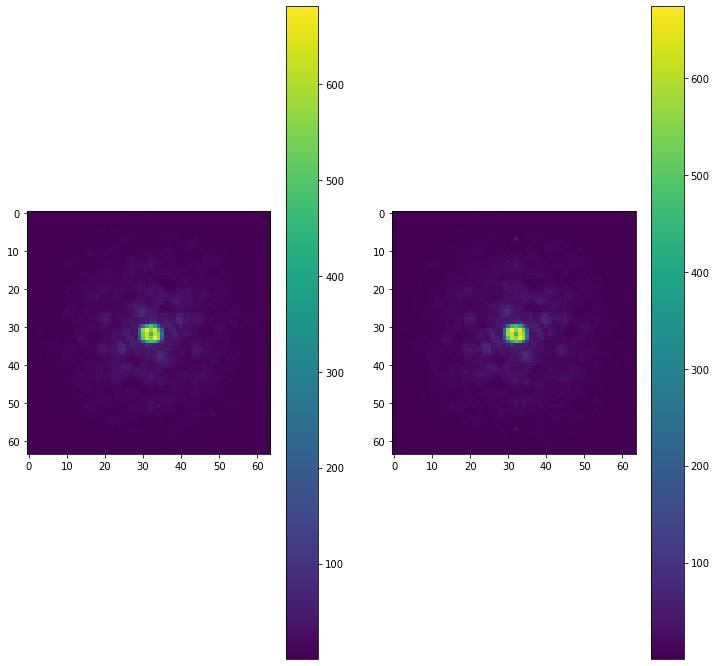

In [374]:
plt.rcParams["figure.figsize"]= 12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.real(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.real(v_rec_o2))); plt.colorbar()

plt.rcParams["figure.figsize"]= 6, 6


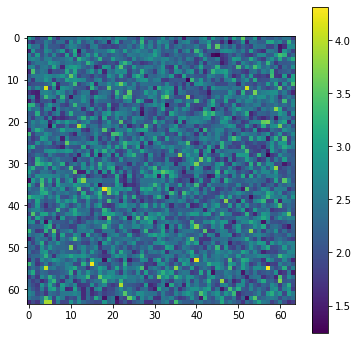

In [375]:
mip_z(np.imag(x01-x02)); plt.colorbar()

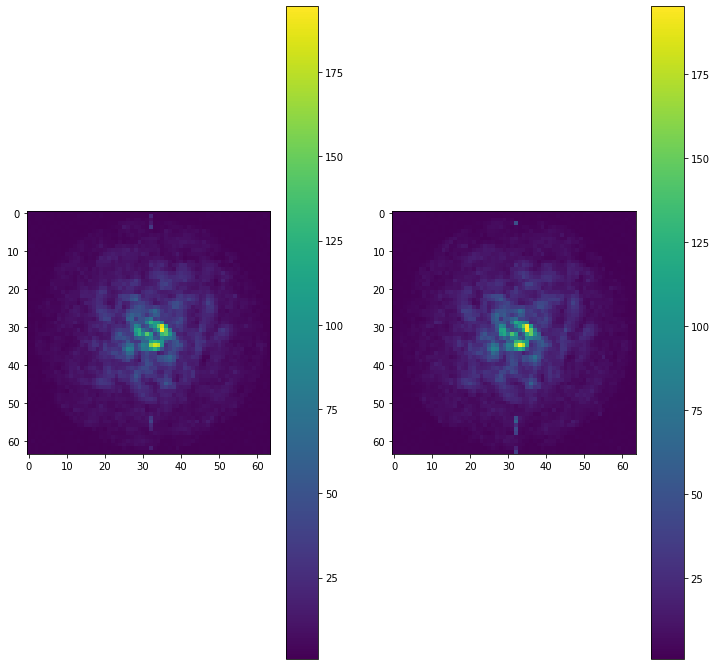

In [376]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec_o2))); plt.colorbar()

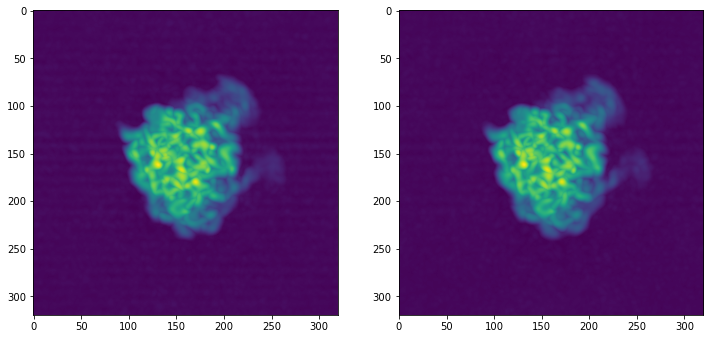

In [377]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [378]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

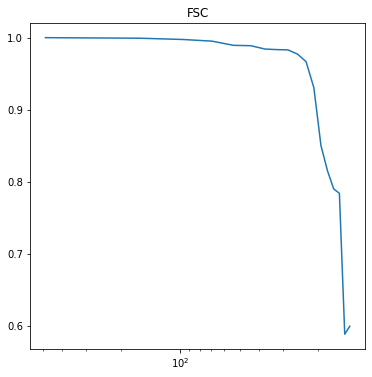

In [379]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

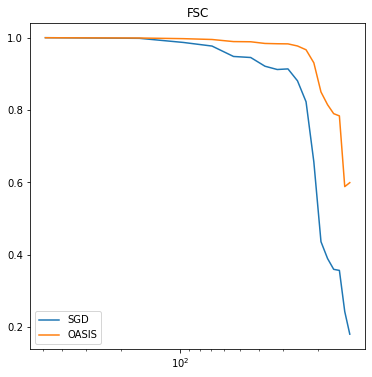

In [380]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

In [381]:
print(fsc_o[18])
print(fsc_o[13])
print(res_angs[32])
print(res_angs[33])

0.5992989188334154
0.8146872597754345
13.830013305388063
13.830013305388063


In [382]:
res_angs

DeviceArray([484.05046569, 161.35015523,  96.81009314,  69.15006653,
              53.78338508,  44.00458779,  37.23465121,  32.27003105,
              28.47355681,  25.4763403 ,  23.05002218,  21.04567242,
              19.36201863,  17.92779503,  16.69139537,  15.61453115,
              14.66819593,  13.83001331], dtype=float64)

In [383]:
#Nn = N//2

In [ ]:
#loss_func1(v_rec1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec2, jnp.arange(Nn))

In [ ]:
#loss_func1(v_rec_o1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec_o2, jnp.arange(Nn))

#### Now the same with CG

In [97]:
N_iter = 300


In [98]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


In [99]:
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

v_rec_cg1, _ = cg(AA1, Ab1, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 391.2522179346807
  cg iter 10 ||r|| = 25.262535234593372
  cg iter 20 ||r|| = 5.323958072478355
  cg iter 30 ||r|| = 1.512414581970766
  cg iter 40 ||r|| = 0.5340895352426769
  cg iter 50 ||r|| = 0.26594636935706506
  cg iter 60 ||r|| = 0.18223602830948302
  cg iter 70 ||r|| = 0.1471368721567126
  cg iter 80 ||r|| = 0.1304789629318093
  cg iter 90 ||r|| = 0.11897611213368159
  cg iter 100 ||r|| = 0.09800525027357462
  cg iter 110 ||r|| = 0.08952407861475824
  cg iter 120 ||r|| = 0.07046637857963803
  cg iter 130 ||r|| = 0.054301260050115305
  cg iter 140 ||r|| = 0.04517852423513487
  cg iter 150 ||r|| = 0.040908620376511814
  cg iter 160 ||r|| = 0.036941515425223934
  cg iter 170 ||r|| = 0.032165789058225897
  cg iter 180 ||r|| = 0.025527554164427854
  cg iter 190 ||r|| = 0.019395378622548674
  cg iter 200 ||r|| = 0.014096415699019444
  cg iter 210 ||r|| = 0.010480818407819375
  cg iter 220 ||r|| = 0.007937216061370876
  cg iter 230 ||r|| = 0.006610147606805102
  c

In [100]:
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

v_rec_cg2, _ = cg(AA2, Ab2, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 395.22226193094906
  cg iter 10 ||r|| = 24.637805588594468
  cg iter 20 ||r|| = 5.253322559708153
  cg iter 30 ||r|| = 1.6056046378395445
  cg iter 40 ||r|| = 0.5953006422983289
  cg iter 50 ||r|| = 0.33149046268064475
  cg iter 60 ||r|| = 0.24056011865243487
  cg iter 70 ||r|| = 0.2095478120151368
  cg iter 80 ||r|| = 0.19750270343329512
  cg iter 90 ||r|| = 0.17415919041586786
  cg iter 100 ||r|| = 0.14161915820672305
  cg iter 110 ||r|| = 0.13173961294070025
  cg iter 120 ||r|| = 0.13019198739918988
  cg iter 130 ||r|| = 0.10314678406106154
  cg iter 140 ||r|| = 0.09528615086954662
  cg iter 150 ||r|| = 0.0874605646268831
  cg iter 160 ||r|| = 0.06810021997023673
  cg iter 170 ||r|| = 0.049338057473205355
  cg iter 180 ||r|| = 0.03437918129728903
  cg iter 190 ||r|| = 0.03009875678227613
  cg iter 200 ||r|| = 0.03084339266538064
  cg iter 210 ||r|| = 0.027146338667111348
  cg iter 220 ||r|| = 0.02287385017975901
  cg iter 230 ||r|| = 0.02155800277803658
  cg iter

In [101]:
Nn=N//2

In [364]:
loss_func1(v_rec_cg1, jnp.arange(Nn))

DeviceArray(3.17032962e+08, dtype=float64)

In [365]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

DeviceArray(3.18733994e+08, dtype=float64)

In [366]:
loss_func2(v_rec2, jnp.arange(Nn))

DeviceArray(3.18788209e+08, dtype=float64)

In [367]:
loss_func2(v_rec_o2, jnp.arange(Nn))

DeviceArray(3.40805871e+08, dtype=float64)

In [368]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

DeviceArray(3.18733994e+08, dtype=float64)

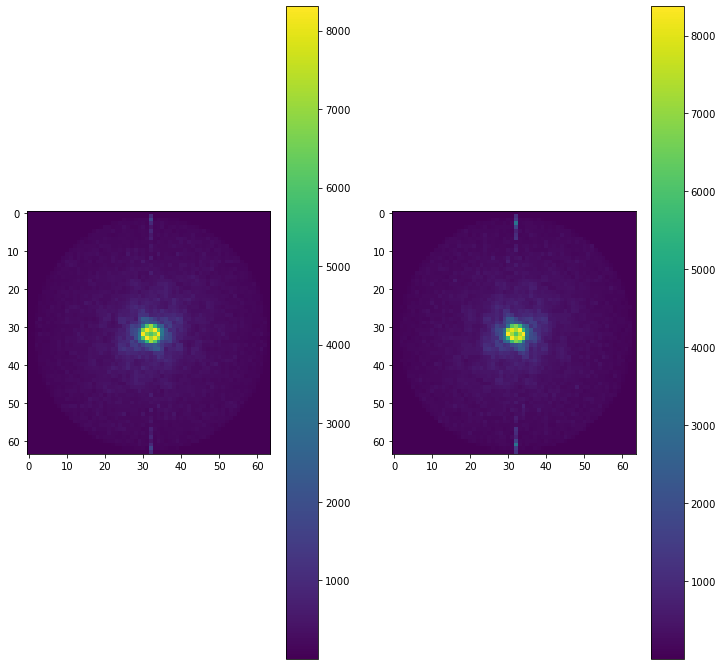

In [104]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

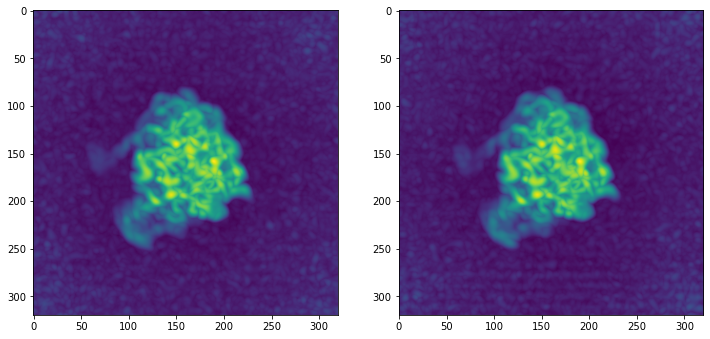

In [145]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [106]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

Text(0.5, 1.0, 'FSC')

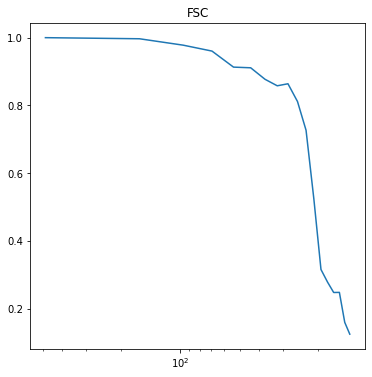

In [167]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
#res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [168]:
fsc_cg

DeviceArray([1.        , 0.99676067, 0.97785628, 0.96036993, 0.91304574,
             0.91106108, 0.87717424, 0.85790955, 0.86391366, 0.81157142,
             0.72669519, 0.52420732, 0.31555519, 0.27823127, 0.24768372,
             0.24799475, 0.15949017, 0.12464337], dtype=float64)

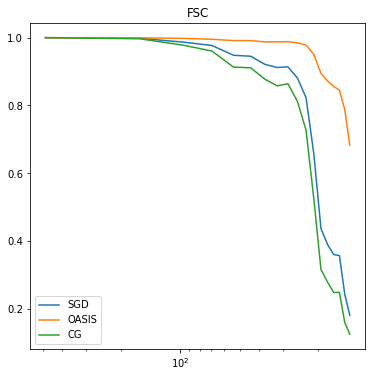

In [295]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

In [115]:
print(fsc_cg[11])
print(fsc_cg[12])
print(res_angs[11])
print(res_angs[12])

0.5242073183408567
0.3155551853363117
21.04567242124271
19.362018627543293


### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning).
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

# I think I need to re-run all the experiments below, and carefully choose the learning rate/step size, all at 30 epochs and with SEPARATE randomly initialized x0 and random seeds (for OASIS)

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 30 epochs (for SGD/OASIS) and 300 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

no $\sigma_{noise}$:
* SGD no precon: $\approx 20 Å$ V
* SGD with precon:  $\approx 20 Å$ V
* OASIS: $FSC \geq 0.6$, V (the FSC curve is almost identical to SGD with precon - this is no longer true, not sure why)
* CG: $\approx 20 Å$, V, the FSC curve is almost identical with SGD precon 

with $\sigma_{noise}$:

* SGD no precon:  | $\approx 20 Å$ 
* SGD with precon: | $\approx 20 Å$ 
* OASIS: | above $FSC \geq 0.65$ all the way
* CG: | no convergence for some reason 

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 3 epochs:

no $\sigma_{noise}$:
* SGD no precon: $\approx 13.8 Å$ with reg $10^{-5}$ and 3 epochs; $\approx 16 Å$ with regularization $10^{-9}$ and 30 epochs (but not needed this many).
* SGD with precon: $\approx 6.63 Å$ (max for 128px), $FSC \geq 0.75$ all the way with regularization $10^{-5}$; noise is amplified for reg param $10^{-9}$. 
* OASIS: $\approx 6.63 Å$ (max for 128px), $FSC \geq 0.75$ all the way with regularization $10^{-5}$, and the FSC curve is identical to SGD with precon; for reg param $10^{-9}$, noise is amplified.

Actually, everything above must be reran (small and large) since I changed the initialization, and everything below should be run again with 30 epochs a.k.a. to convergence -- look at convergence plots

with $\sigma_{noise}$: 
* SGD no precon: $\approx 13 Å$ with reg $10^{-9}$, 30 epochs
* SGD with precon: 
* OASIS: $\approx 9.3 Å$ with reg $10^{-9}$ 30 epochs. (The OASIS and SGD with precon FSC curves are almost identical, as expected in this case. NOT YET)
    And with slightly larger step size, the FSC is good (res $\approx 7 Å$) but the imaginary part explodes. WHY

# TODO:

* Need to rerun the stuff above with better learning rate tuning and/or maybe slightly larger regularization param for OASIS/SGD with precon
* Also fix the handling of the imaginary part -- I don't know if the loss for OASIS explodes in imaginary part only because of this issue or because of the low regularization param.

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [ ]:
f(x0)

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
plt.plot(loss_n)

In [ ]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

In [ ]:
F(x_cg)

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 10000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* Run on CryoEM data